<a href="https://colab.research.google.com/github/Mirucla/Applied-Data-Management/blob/main/Machine_Learning_Time_Series_Project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
import numpy as np 
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import warnings

In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# 1. Uploading the data and Formatting the date

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive/', force_remount = True)

Mounted at /content/gdrive/


In [ ]:
df=pd.read_csv('/content/gdrive/MyDrive/BTC-Daily.csv')

In [ ]:
df.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1646092800,2022-03-01 00:00:00,BTC/USD,43221.71,43626.49,43185.48,43185.48,49.006289,2.116360e+06
1,1646006400,2022-02-28 00:00:00,BTC/USD,37717.10,44256.08,37468.99,43178.98,3160.618070,1.364723e+08
2,1645920000,2022-02-27 00:00:00,BTC/USD,39146.66,39886.92,37015.74,37712.68,1701.817043,6.418008e+07
3,1645833600,2022-02-26 00:00:00,BTC/USD,39242.64,40330.99,38600.00,39146.66,912.724087,3.573010e+07
4,1645747200,2022-02-25 00:00:00,BTC/USD,38360.93,39727.97,38027.61,39231.64,2202.851827,8.642149e+07


In [ ]:
df.describe

<bound method NDFrame.describe of             unix                 date   symbol      open      high       low  \
0     1646092800  2022-03-01 00:00:00  BTC/USD  43221.71  43626.49  43185.48   
1     1646006400  2022-02-28 00:00:00  BTC/USD  37717.10  44256.08  37468.99   
2     1645920000  2022-02-27 00:00:00  BTC/USD  39146.66  39886.92  37015.74   
3     1645833600  2022-02-26 00:00:00  BTC/USD  39242.64  40330.99  38600.00   
4     1645747200  2022-02-25 00:00:00  BTC/USD  38360.93  39727.97  38027.61   
...          ...                  ...      ...       ...       ...       ...   
2646  1417478400  2014-12-02 00:00:00  BTC/USD    378.39    382.86    375.23   
2647  1417392000  2014-12-01 00:00:00  BTC/USD    376.40    382.31    373.03   
2648  1417305600  2014-11-30 00:00:00  BTC/USD    376.57    381.99    373.32   
2649  1417219200  2014-11-29 00:00:00  BTC/USD    376.42    386.60    372.25   
2650  1417132800  2014-11-28 00:00:00  BTC/USD    363.59    381.34    360.57   

     

In [ ]:
df.shape

(2651, 9)

In [ ]:
# Convert the 'date' column to a pandas datetime object and set it as the index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Keep only the 'close' column
df = df[['close']]

# Setting a Daily frequency and forward fill missing values
df = df.asfreq('D').ffill()
df.head()

,close
date,
2014-11-28,376.28
2014-11-29,376.72
2014-11-30,373.34
2014-12-01,378.39
2014-12-02,379.25


In [ ]:
df['close'].shape

(2651,)

In [ ]:
# Checking whether there is any null value 

In [ ]:
df.isnull().sum()

close    0
dtype: int64

# 2. Exploratory Data Analysis (EDA)

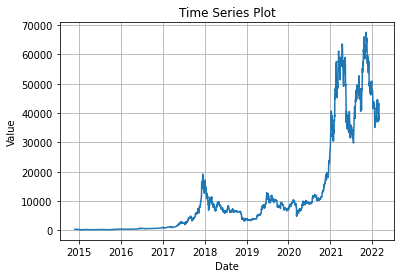

In [ ]:
# Create a time series plot
plt.plot(df.index, df['close'])
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid()
plt.show()

As we can observe from the time series plot, the price data is not covariance stationary. Its mean and variance are not constant over time and they are changing over time. This kind of data is not fit for running any kind of time sereis modelling. We need to make the data stationary before applying the model 

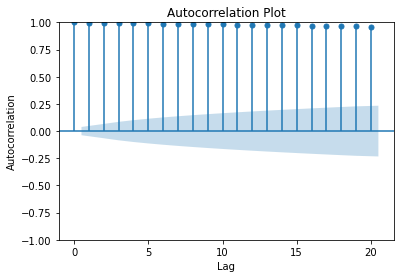

In [ ]:
# Create an autocorrelation plot
plot_acf(df['close'], lags=20)
plt.title('Autocorrelation Plot')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

As we can observe from the autocorrelation graph, the data is almost perfectly positively correlated. Having autocorrelation of 1 for every lag can be problematic as it violates the assumption of independence, makes statistical tests unreliable, and suggests the presence of unmodeled processes.Therefore, we need to address this issue. We need to look for trends, seasonality, or other patterns that may be causing the autocorrelation.We may use the differencing to remove a trend or seasonality from the data.

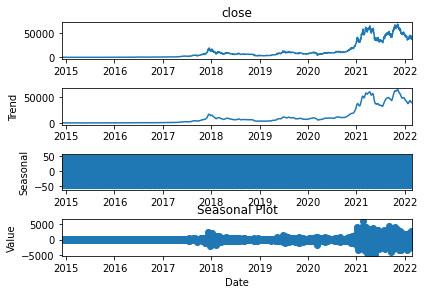

<Figure size 1440x720 with 0 Axes>

In [ ]:
# Create a seasonal plot
seasonal_decomposition = sm.tsa.seasonal_decompose(df['close'], model='additive', period=12)
seasonal_decomposition.plot()
plt.title('Seasonal Plot')
plt.xlabel('Date')
plt.ylabel('Value')
plt.figure(figsize=(20, 10))
plt.show()

The seasonal pattern is small relative to the overall level of the data, it may not be a significant problem. Moreover, the seasonal pattern is consistent and predictable. Therefore, this may not be probelm for prediction as well. 

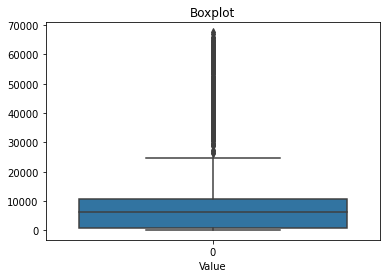

In [ ]:
# Create a boxplot
sns.boxplot(df['close'])
plt.title('Boxplot')
plt.xlabel('Value')
plt.ylabel('')
plt.show()

As we can observe from the boxplot, there are many genuine outliers in the dataset. when there are a lot of genuine extreme outliers in a dataset, it can be challenging to determine how to deal with them. We may consider transforming the data, using robust statistical methods, removing outliers. However, we are not considering removing the outliers as they are genuine. 

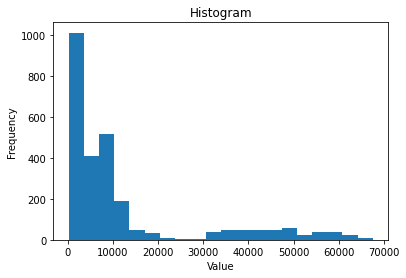

In [ ]:
# Create a histogram
plt.hist(df['close'], bins=20)

# Set the plot title and axis labels
plt.title('Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Display the plot
plt.show()

From the histogram, we also observe that there are many genuine outliers and the time series plot also shows that the price of bitcoin has increased exceedingly over time. 

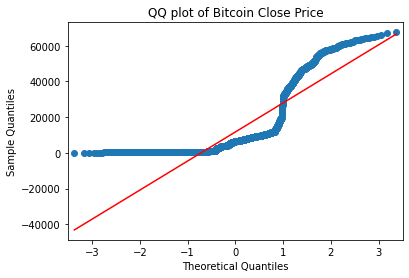

In [ ]:
sm.qqplot(df['close'], line='s')
plt.title('QQ plot of Bitcoin Close Price')
plt.show()

QQ plot validates the fact that there are extreeme outliers int the dataset. Therefore, we need to adddress this issue. Moreover, the data is not normally distributed as it is not close to 45 degree line in the QQ Plot. 

# 3. Addressing the issue of outliers, seasonality and other patterns of the data 

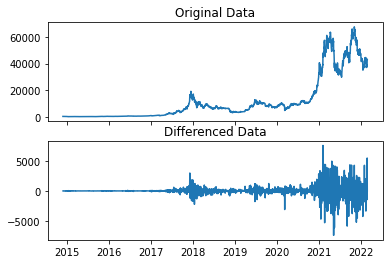

In [ ]:
# Difference the data to remove trends
df_diff = df.diff().dropna()

# Plot the original and differenced data
fig, axs = plt.subplots(2, sharex=True, sharey=False)
axs[0].plot(df)
axs[0].set(title='Original Data')
axs[1].plot(df_diff)
axs[1].set(title='Differenced Data')
plt.show()

When we take the first difference, we observe that the data seems normal except some volatility in the year 2021 and 2022. Based on this transformation, we can model the data for future prediction. 

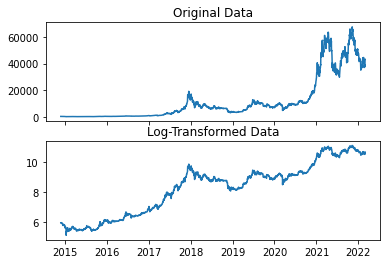

In [ ]:
# Take the log transformation of the data
df_log = np.log(df)
fig, axs = plt.subplots(2, sharex=True, sharey=False)
axs[0].plot(df)
axs[0].set(title='Original Data')
axs[1].plot(df_log)
axs[1].set(title='Log-Transformed Data')
plt.show()

As we can observe from the log-transformed graph, it is not that much helpful as the data does not look normal after log transformation. Therefore, log transformation is not effective in addressing the issue of outliers and skewness in the dataset. 

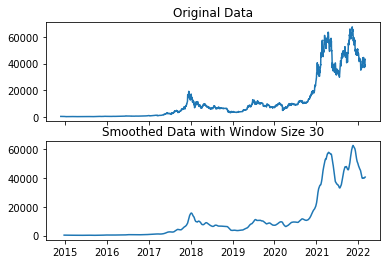

In [ ]:
# Apply moving average smoothing with window size 7
window_size = 30
df_ma = df.rolling(window=window_size).mean()
fig, axs = plt.subplots(2, sharex=True, sharey=False)
axs[0].plot(df)
axs[0].set(title='Original Data')
axs[1].plot(df_ma)
axs[1].set(title='Smoothed Data with Window Size {}'.format(window_size))
plt.show()

As can be observed, smoothing the data with window size does not help much as the patter of the data is almost similar. It is not addressing the issue of outliers and skewness in the dataset. 

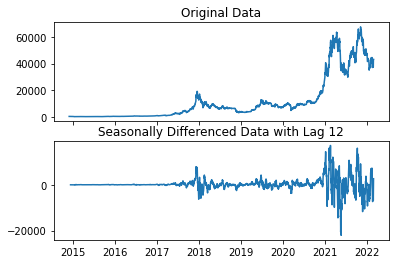

In [ ]:
# Apply seasonal differencing with lag 12 (i.e., 1 year)
lag = 12
df_seasonal_diff = df.diff(lag)
fig, axs = plt.subplots(2, sharex=True, sharey=False)
axs[0].plot(df)
axs[0].set(title='Original Data')
axs[1].plot(df_seasonal_diff)
axs[1].set(title='Seasonally Differenced Data with Lag {}'.format(lag))
plt.show()

Surprisingly the seasonal differencing is mostly effective in addressing the issue of outliers and skewness in the dataset. Though there are highl volatility in 2021 and 2022 period, we can apply seasonal differencing as well to address the issue of outliers and other irregula patterns. 

# 4. ADF and KPSS test before differencing 

In [ ]:
# Perform ADF test
adf_result = adfuller(df['close'])
print('ADF statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical values:', adf_result[4])

ADF statistic: -0.9875841417510546
p-value: 0.7577657213555864
Critical values: {'1%': -3.4328464582522136, '5%': -2.8626429445545245, '10%': -2.5673571362774994}


In [ ]:
# Perform KPSS test
kpss_result = kpss(df['close'])
print('KPSS statistic:', kpss_result[0])
print('p-value:', kpss_result[1])
print('Critical values:', kpss_result[3])

KPSS statistic: 5.261962766047119
p-value: 0.01
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


As we can observe from the ADF and KPSS test, the data is not stationary as ADF test is not significant whereby null hypothesis is that the data is stationary. We fail to reject the null. In KPSS test, the null hypothesis is that the data is not stationary. As p value is significant, we reject the null hypothesis. 

# 5. ADF and KPSS Test after differencing 

# Differencing to remove trends 

In [ ]:
# Perform ADF test
adf_result = adfuller(df_diff['close'])
print('ADF statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical values:', adf_result[4])

ADF statistic: -8.47850283038204
p-value: 1.4139138299595207e-13
Critical values: {'1%': -3.43284741167062, '5%': -2.8626433656018726, '10%': -2.5673573604457642}


In [ ]:
# Perform KPSS test
kpss_result = kpss(df_diff['close'])
print('KPSS statistic:', kpss_result[0])
print('p-value:', kpss_result[1])
print('Critical values:', kpss_result[3])

KPSS statistic: 0.12414816896696627
p-value: 0.1
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


# Seasonal Differencing to remove the trends 

In [ ]:
df_seasonal_diff.isnull().sum()

close    12
dtype: int64

In [ ]:
diff_seasonal = df_seasonal_diff.dropna()

In [ ]:
diff_seasonal.isnull().sum()

close    0
dtype: int64

In [ ]:
# Perform ADF test
adf_result = adfuller(diff_seasonal['close'])
print('ADF statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical values:', adf_result[4])

ADF statistic: -6.461125913680091
p-value: 1.4423745756460264e-08
Critical values: {'1%': -3.4328541060447755, '5%': -2.8626463219585556, '10%': -2.5673589344293486}


In [ ]:
# Perform KPSS test
kpss_result = kpss(diff_seasonal['close'])
print('KPSS statistic:', kpss_result[0])
print('p-value:', kpss_result[1])
print('Critical values:', kpss_result[3])

KPSS statistic: 0.1131895189329386
p-value: 0.1
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


As can be observed from ADF and KPSS test, we can say that data is now stationary after both differencing and seasonal differencing. 

# 6. Plots after differencing and seasonal differencing

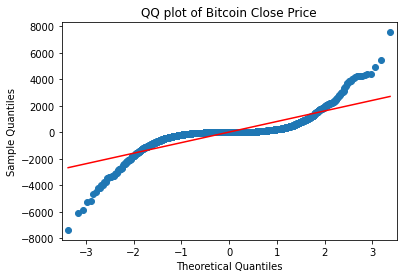

In [ ]:
sm.qqplot(df_diff['close'], line='s')
plt.title('QQ plot of Bitcoin Close Price')
plt.show()

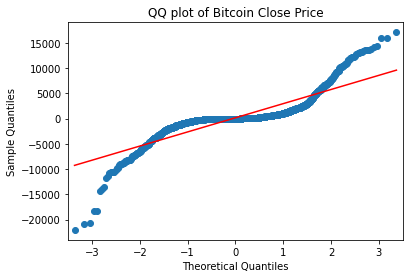

In [ ]:
sm.qqplot(diff_seasonal['close'], line='s')
plt.title('QQ plot of Bitcoin Close Price')
plt.show()

As can be observed from the QQ Plot, the data is now more normal than earlier. 

# 7. Train Test Split using original data 

In [ ]:
train, test = df['close'][:1855], df['close'][1855:]

In [ ]:
# first differencing the train data 
diff_train = train.diff().dropna()
diff_train.head()

date
2014-11-29    0.44
2014-11-30   -3.38
2014-12-01    5.05
2014-12-02    0.86
2014-12-03   -2.58
Freq: D, Name: close, dtype: float64

# ARIMA Model

In [ ]:
# Fit an ARIMA model to the training data
model = ARIMA(diff_train, order=(1, 1, 1))
model_fit = model.fit()

In [ ]:
# Generate predictions for the testing data
predictions = model_fit.predict(start=len(diff_train), end=len(diff_train)+len(test)-1)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate the MSE, RMSE, and MAE for the predicted values
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, predictions)
print(f'MSE: {mse}, RMSE: {rmse}, MAE: {mae}')

MSE: 1268038291.7086291, RMSE: 35609.525294626284, MAE: 29991.683445078466


In [ ]:
# Generate predictions for a simple baseline model
baseline_predictions = np.full(len(test), train.mean())

# Calculate the MSE, RMSE, and MAE for the baseline model predictions
baseline_mse = mean_squared_error(test, baseline_predictions)
baseline_rmse = np.sqrt(baseline_mse)
baseline_mae = mean_absolute_error(test, baseline_predictions)

# Compare the evaluation metrics for the ARIMA model and the baseline model
print(f'ARIMA: MSE={mse:.2f}, RMSE={rmse:.2f}, MAE={mae:.2f}')
print(f'Baseline: MSE={baseline_mse:.2f}, RMSE={baseline_rmse:.2f}, MAE={baseline_mae:.2f}')

ARIMA: MSE=1268038291.71, RMSE=35609.53, MAE=29991.68
Baseline: MSE=1051446291.77, RMSE=32426.01, MAE=26132.53


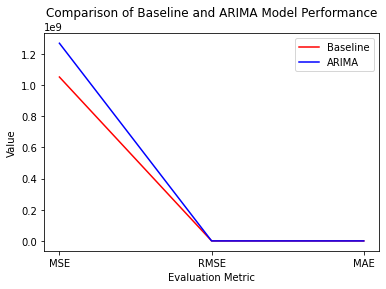

In [ ]:
# Define the evaluation metrics for the baseline and ARIMA models
ARIMA_MSE=1268038291.81
ARIMA_RMSE=35609.53
ARIMA_MAE=29991.68
Baseline_MSE=1051446291.77
Baseline_RMSE=32426.01
Baseline_MAE=26132.53
# Define the labels for the x-axis
labels = ['MSE', 'RMSE', 'MAE']

# Define the baseline values and the ARIMA values
baseline_values = [Baseline_MSE, Baseline_RMSE, Baseline_MAE]
arima_values = [ARIMA_MSE, ARIMA_RMSE, ARIMA_MAE]

# Define the colors for the baseline and ARIMA lines
baseline_color = 'red'
arima_color = 'blue'

# Plot the baseline line
plt.plot(labels, baseline_values, label='Baseline', color=baseline_color)

# Plot the ARIMA line
plt.plot(labels, arima_values, label='ARIMA', color=arima_color)

# Add labels and a legend to the plot
plt.xlabel('Evaluation Metric')
plt.ylabel('Value')
plt.title('Comparison of Baseline and ARIMA Model Performance')
plt.legend()
plt.show()

# LSTM Model 

In [ ]:
# scale the differenced train data using a MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(diff_train.values.reshape(-1, 1))

In [ ]:
# create sequences of length 10 for the training data
seq_length = 10
X_train, y_train = [], []
for i in range(seq_length, len(diff_train)):
    X_train.append(diff_train[i-seq_length:i])
    y_train.append(diff_train[i])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
# reshape the data for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
# build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# train the LSTM model
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
58/58 [==============================] - 7s 9ms/step - loss: 76225.1016
Epoch 2/50
58/58 [==============================] - 1s 10ms/step - loss: 76211.5312
Epoch 3/50
58/58 [==============================] - 1s 10ms/step - loss: 76194.1172
Epoch 4/50
58/58 [==============================] - 1s 10ms/step - loss: 76176.3672
Epoch 5/50
58/58 [==============================] - 1s 11ms/step - loss: 76155.1562
Epoch 6/50
58/58 [==============================] - 1s 11ms/step - loss: 76121.2266
Epoch 7/50
58/58 [==============================] - 1s 11ms/step - loss: 76088.8047
Epoch 8/50
58/58 [==============================] - 1s 11ms/step - loss: 76060.3203
Epoch 9/50
58/58 [==============================] - 1s 10ms/step - loss: 76026.5547
Epoch 10/50
58/58 [==============================] - 1s 11ms/step - loss: 75992.5469
Epoch 11/50
58/58 [==============================] - 1s 10ms/step - loss: 75957.8359
Epoch 12/50
58/58 [==============================] - 1s 11ms/step - loss: 7

In [ ]:
# make predictions on the test data
inputs = diff_train[len(diff_train) - len(test) - seq_length:].values.reshape(-1,1)
inputs = scaler.transform(inputs)
X_test = []
for i in range(seq_length, inputs.shape[0]):
    X_test.append(inputs[i-seq_length:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_diff = model.predict(X_test)
predicted_diff = scaler.inverse_transform(predicted_diff)

25/25 [==============================] - 1s 5ms/step


In [ ]:
# add the predicted differences to the last observed value of the training data
predicted_price = []
last_observed = train.iloc[-1]
for i in range(len(predicted_diff)):
    last_observed += predicted_diff[i]
    predicted_price.append(last_observed)

In [ ]:
# calculate evaluation metrics
mse = mean_squared_error(test, predicted_price)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, predicted_price)

# print the evaluation metrics
print(f'LSTM with first differencing: MSE={mse:.2f}, RMSE={rmse:.2f}, MAE={mae:.2f}')

LSTM with first differencing: MSE=161470296509372.59, RMSE=12707096.31, MAE=12707081.80


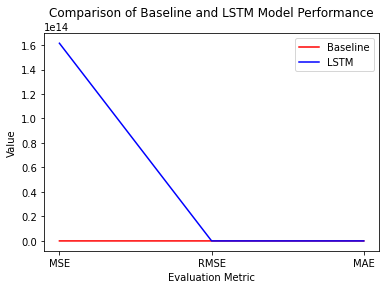

In [ ]:
# Define the evaluation metrics for the baseline and ARIMA models
LSTM_MSE=161470296509372.59
LSTM_RMSE=12707096.31
LSTM_MAE=12707081.80
Baseline_MSE=1051446291.77
Baseline_RMSE=32426.01
Baseline_MAE=26132.53
# Define the labels for the x-axis
labels = ['MSE', 'RMSE', 'MAE']

# Define the baseline values and the ARIMA values
baseline_values = [Baseline_MSE, Baseline_RMSE, Baseline_MAE]
LSTM_values = [LSTM_MSE, LSTM_RMSE, LSTM_MAE]

# Define the colors for the baseline and ARIMA lines
baseline_color = 'red'
LSTM_color = 'blue'

# Plot the baseline line
plt.plot(labels, baseline_values, label='Baseline', color=baseline_color)

# Plot the ARIMA line
plt.plot(labels, LSTM_values, label='LSTM', color=arima_color)

# Add labels and a legend to the plot
plt.xlabel('Evaluation Metric')
plt.ylabel('Value')
plt.title('Comparison of Baseline and LSTM Model Performance')
plt.legend()
plt.show()